In [22]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np

In [23]:
driver = 'mysql+pymysql:'
user = 'root'
password = '17028854'
ip = '35.195.111.11'
database = 'Avocalypse'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

# Google searches of "Avocado": On-line popularity

In [24]:
gtrend = pd.read_sql('gtrend',con=engine)

In [25]:
gtrend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 4 columns):
index         183 non-null int64
year          183 non-null object
month         183 non-null object
popularity    183 non-null object
dtypes: int64(1), object(3)
memory usage: 5.8+ KB


In [26]:
gtrend['year'] = gtrend['year'].astype('int64')
gtrend['month'] = gtrend['month'].astype('int64')
gtrend['popularity'] = gtrend['popularity'].astype('int64')

In [27]:
sb.set(rc={'figure.figsize':(15,8)})

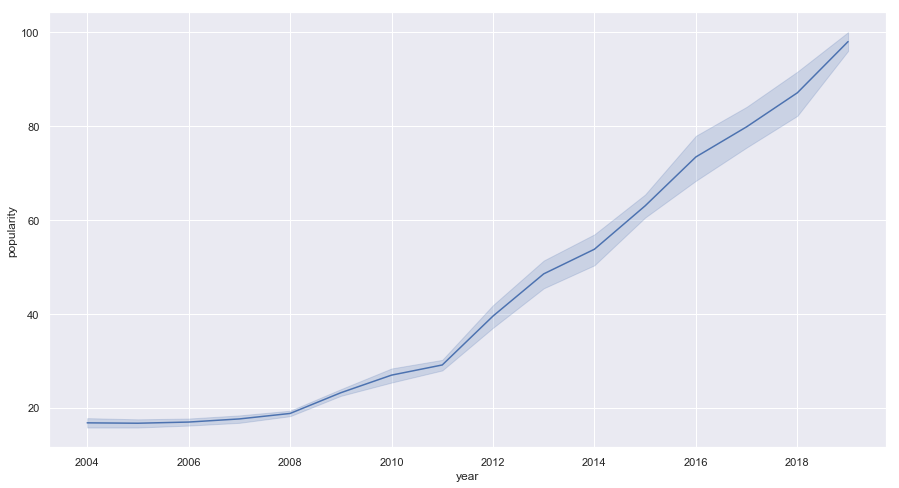

In [28]:
sb.lineplot(data=gtrend, x=gtrend.year, y=gtrend.popularity)
plt.show()

# Production

In [29]:
countries = pd.read_sql('countries',con=engine)
prices = pd.read_sql('prices',con=engine)
production = pd.read_sql('production',con=engine)

In [30]:
countries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
index        52 non-null int64
Area         52 non-null object
Area Code    52 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.3+ KB


In [31]:
countries = countries.drop(columns='index')

In [33]:
production = production.drop(columns='index')

In [34]:
production.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 4 columns):
Area Code             759 non-null int64
Year Code             759 non-null int64
Total_protuction_t    745 non-null float64
Area harvested        745 non-null float64
dtypes: float64(2), int64(2)
memory usage: 23.8 KB


In [35]:
production_countries = production.merge(countries, how='left', on='Area Code')

In [36]:
total_yearly_production = production_countries.groupby('Year Code').sum()['Total_protuction_t']

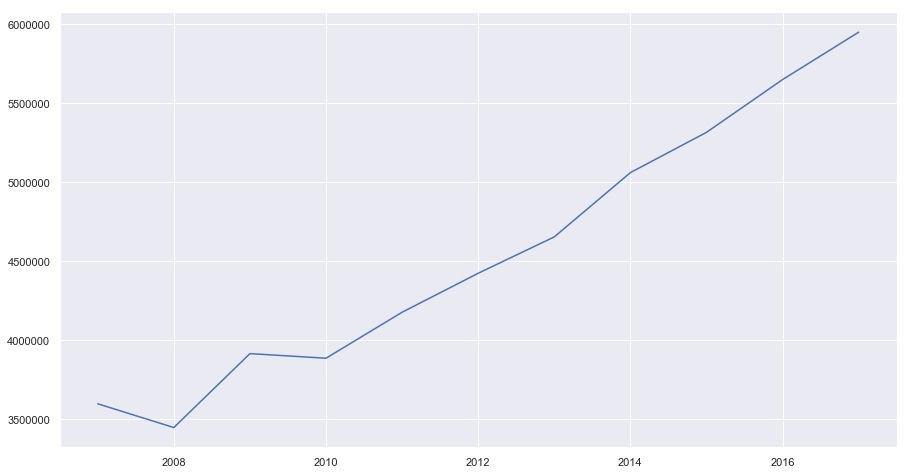

In [37]:
sb.lineplot(data=total_yearly_production)
plt.show()

In [39]:
incr = (total_yearly_production.max()-total_yearly_production.min())/total_yearly_production.min()
print(f'The increase in the production of avocados has been of {incr}% in the last years')

The increase in the production of avocados has been of 0.7272834927115209% in the last years


In [40]:
production_countries['production_share'] = production_countries['Total_protuction_t'].div(production_countries.groupby('Year Code')['Total_protuction_t'].transform('sum'))

In [41]:
top_10_countries_yearly = production_countries.groupby(['Area','Year Code']).sum().sort_values('Total_protuction_t',ascending=False).head(110)[['Total_protuction_t','Area harvested','production_share']].reset_index()

top10_2016 = top_10_countries_yearly[top_10_countries_yearly['Year Code'] == 2016]



In [42]:
top10_2016['cumulative_share'] = top10_2016['production_share'].cumsum()

/usr/local/Cellar/ipython/7.2.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
top10_2016 = top10_2016.reset_index(drop=True)

We correct by inflation, consumer prices (annual %) extracting data from the World Bank

In [44]:
inflation = pd.DataFrame({'country':['Kenya', 'Mexico', 'Colombia', 'Indonesia', 'Brazil', 'Dominican Republic', 'Peru', 'Chile', 'United States of America', 'China','Venezuela (Bolivarian Republic of)'],'2016_inflation':[8.006,6.041,4.314,3.309,3.446,3.28,2.803,2.182,2.13,1.593,254.949]})

In [49]:
top10_2016 = top10_2016.merge(inflation,how='left', left_on='Area',right_on='country')

We drop Venezuela as it is an outlier considering the inflation in the country

In [50]:
top10_2016 = top10_2016.drop(index=7).reset_index(drop=True)

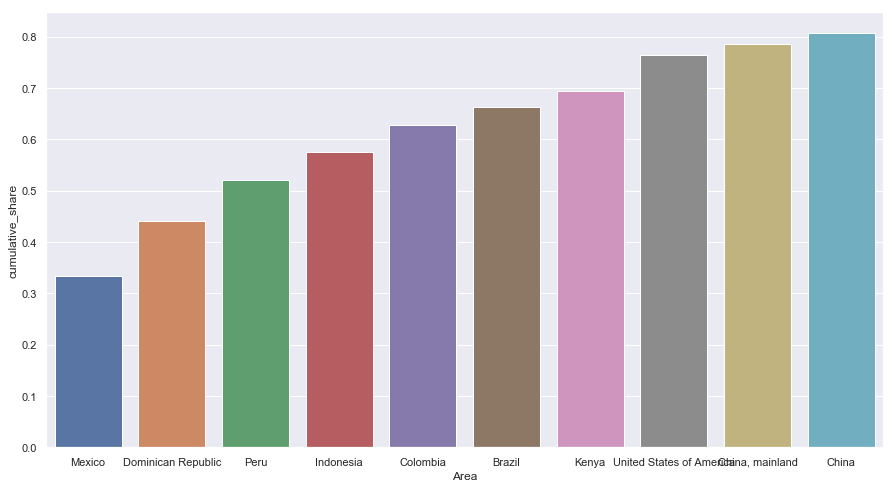

In [51]:
sb.barplot(data=top10_2016,x='Area',y='cumulative_share')
plt.show()

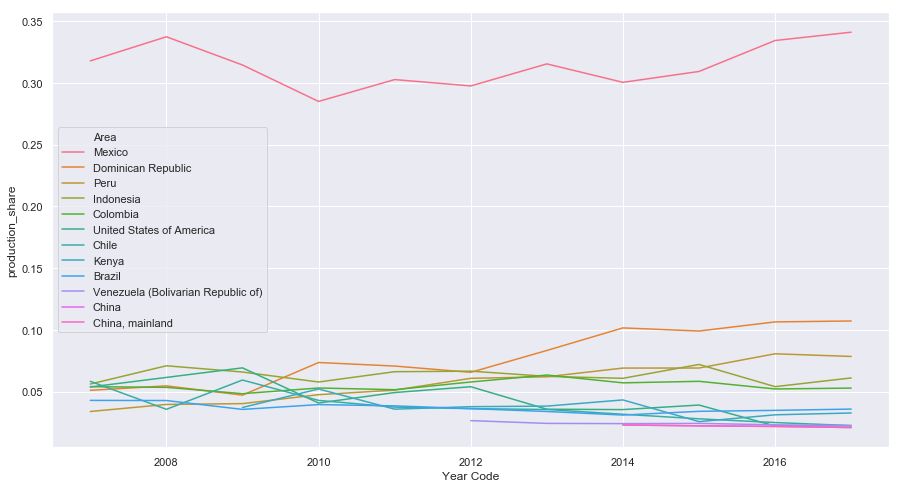

In [52]:
sb.lineplot(data=top_10_countries_yearly,hue='Area',x='Year Code',y='production_share')
plt.show()

# Price

In [53]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 4 columns):
index        527 non-null int64
Area Code    527 non-null int64
Year Code    527 non-null int64
Value        527 non-null float64
dtypes: float64(1), int64(3)
memory usage: 16.5 KB


In [54]:
prices = prices.drop(columns='index')
prices_country = prices.merge(countries, how='left', on='Area Code')

Select only the Top10 producing countries

In [55]:
top10_prices = prices_country[prices_country['Area'].isin(list(top10_2016['Area']))]

In [56]:
top10_prices = top10_prices.reset_index(drop=True)

In [57]:
top10_prices_2016 = top10_prices[top10_prices['Year Code']==2016]

We add inflation to correct the increase in value

In [58]:
top10_prices_2016 = top10_prices_2016.merge(inflation,how='left',left_on='Area',right_on='country')

In [59]:
top10_prices_2016['corrected_value']=top10_prices_2016['Value']/top10_prices_2016['2016_inflation']

In [60]:
top10_prices_2016 = top10_prices_2016.drop(index=3).reset_index()

In [61]:
top10_prices_2016 = top10_prices_2016.reset_index(drop=True)

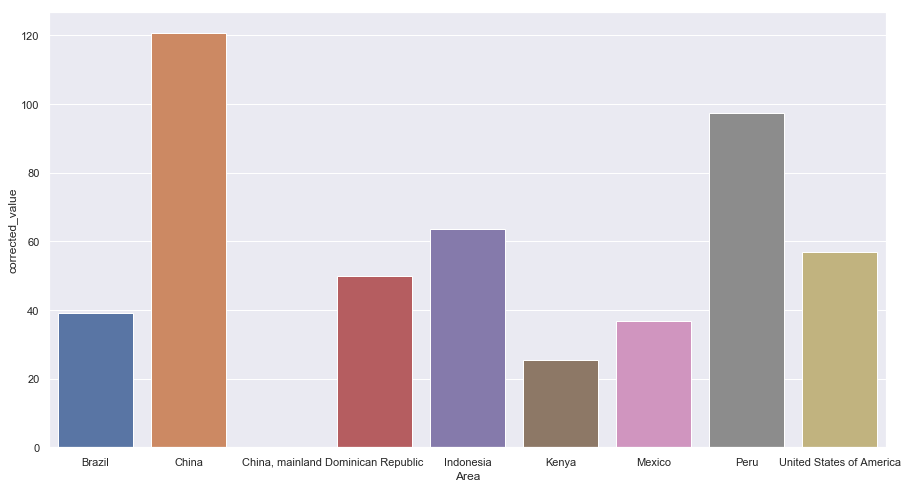

In [62]:
sb.barplot(data=top10_prices_2016,x='Area',y='corrected_value')
plt.show()

The mean to perform the test:

In [63]:
top10_prices_2016['corrected_value'].mean()

61.19371726675027

In [64]:
top10_2016 = top_10_countries_yearly[top_10_countries_yearly['Year Code'] == 2016]
top10_2016_price_prod = top10_2016.merge(top10_prices_2016,on='Area').drop(columns='Year Code_x')
top10_2016_price_prod['Price_ton']=top10_2016_price_prod['Value']*top10_2016_price_prod['Total_protuction_t']/top10_2016_price_prod['Total_protuction_t'].sum()

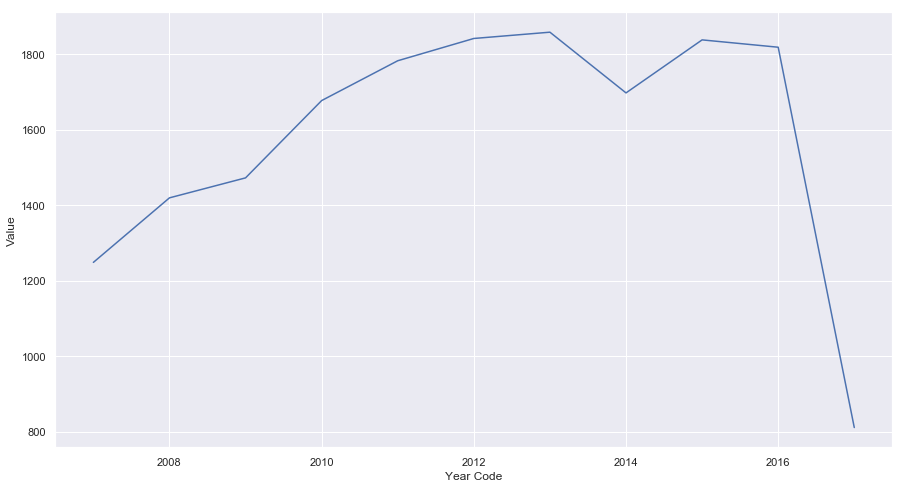

In [67]:
sb.lineplot(data=top10_prices.groupby('Year Code').sum().reset_index(),x='Year Code',y='Value')
plt.show()

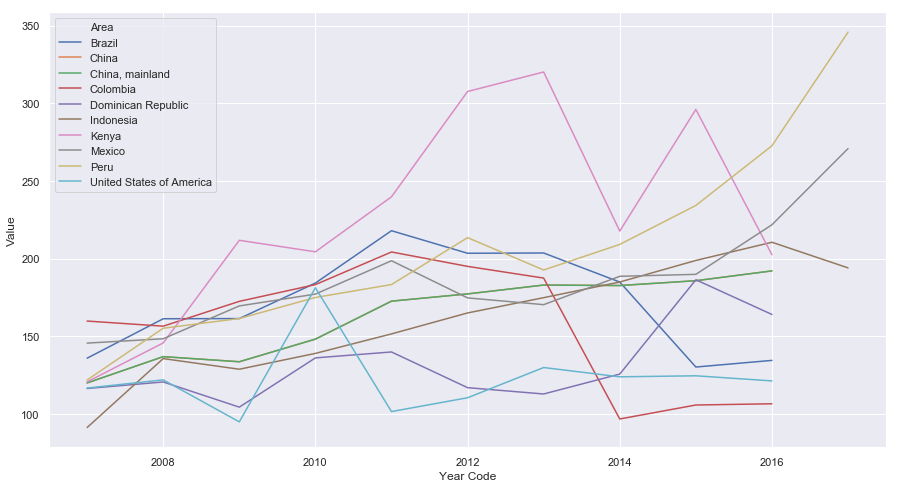

In [69]:
sb.lineplot(data=top10_prices,x='Year Code',y='Value',hue='Area')
plt.show()